In [1]:
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [9]:
def add_lts(network,
             bus, 
             charger='heatpump',
             sts_cap=14,
             sts_charge=2.940,
             sts_discharge=1.260,
             lts_cap=900,
             lts_charge=0.17,
             lts_discharge=0.17,
             ):
    '''
    Adds seasonal storage to bus.
    Default parameters are as in Renaldi, Friedrich 2018
    (Multiple time grids in operational optimisation of energy systems
    with short- and long-term thermal energy storage)
    (units are in megawatts/megawatthours)
    
    Args:
        network(pypsa.Network): network with bus to which storages should be attached
        bus(str): name of bus to which the storage is attached
        charger(str): charging technology employed
        rest: capacity, maximal charge and discharge rates of short-term and long-term storage respectively
    '''

    busname_sts = bus+'_stsbus'
    busname_lts = bus+'_ltsbus'
    name_sts = bus+'_sts'
    name_lts = bus+'_lts'

    network.add('Bus', busname_sts)
    network.add('Bus', busname_lts)

    network.add('Store', 
                name_sts, 
                bus=busname_sts, 
                e_nom=sts_cap,
                )
    network.add('Store', 
                name_lts, 
                bus=busname_lts, 
                e_nom=lts_cap,
                )

    network.add('Link', 
                bus+'_lts2sts', 
                bus0=busname_lts, 
                bus1=busname_sts, 
                p_nom=min([lts_discharge, sts_charge]),
                )
    network.add('Link', 
                'sts2'+bus, 
                bus0=busname_sts, 
                bus1=bus, 
                p_nom=sts_discharge,
                )

    all_chargers = ['heatpump']
    assert charger in all_chargers, f'Charger {charger} not in {all_chargers}'

    if charger == 'heatpump':
        charger_cop = 3.5

    if charger == 'heatpump':
            network.add('Link', 
                        bus+'2lts', 
                        bus0=bus, 
                        bus1=busname_lts, 
                        p_nom=lts_charge,
                        efficiency=charger_cop,
                        )

    

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x136
  Lower bound: 0.5148622462332013
  Upper bound: 0.5148622462332013
  Number of objectives: 1
  Number of constraints: 211
  Number of variables: 136
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 136
  Number of nonzeros: 374
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model 

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\pypsa\opf.py:1285: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



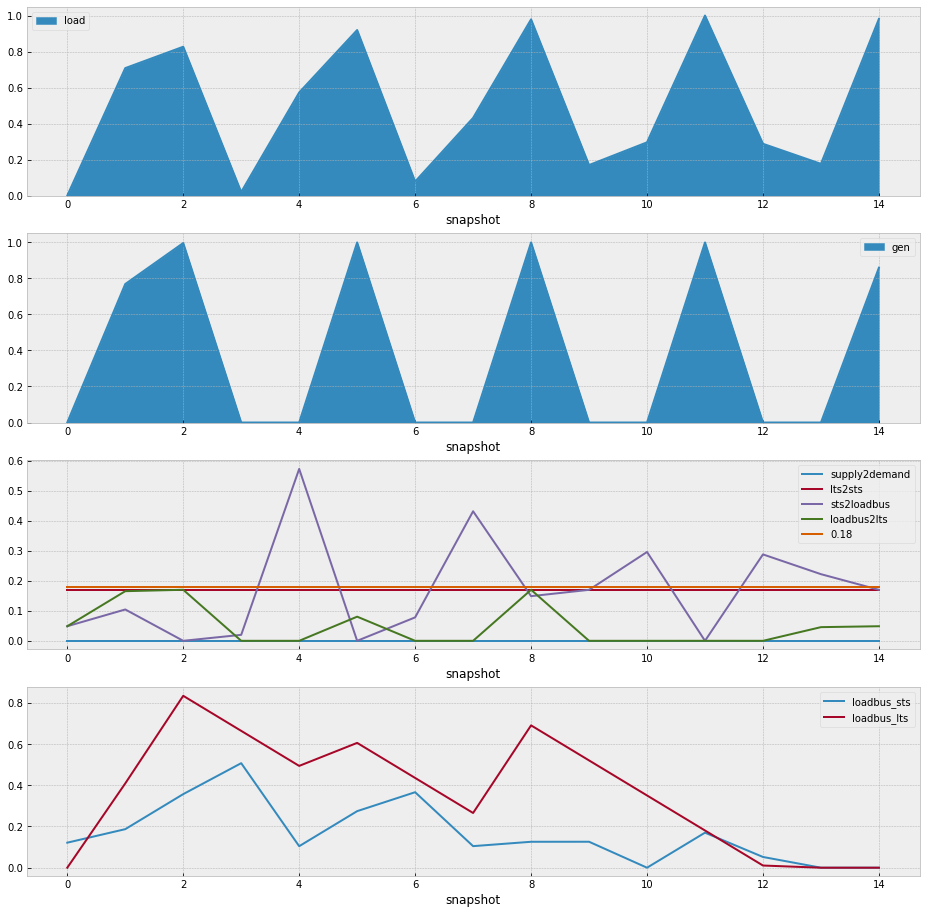

In [15]:
network = pypsa.Network()

snapshots = np.arange(15)
demand = np.sin(snapshots)**2
cost = np.cos(snapshots)**2
supply = np.ones_like(snapshots)

snapshots = pd.Series(snapshots)
demand = pd.Series(demand)
supply = pd.Series(supply)

network.set_snapshots(snapshots)

network.add('Bus', 'loadbus')
network.add('Bus', 'genbus')

network.add('Load', 'load', bus='loadbus', p_set=demand)
network.add('Generator', 'gen', bus='loadbus', p_max_pu=supply, p_nom=1, marginal_cost=cost)

network.add('Link', 'supply2demand', bus0='genbus', bus1='loadbus', p_nom=1)

add_lts(network, 'loadbus')

network.lopf(solver_name='gurobi')


fig, axs = plt.subplots(4, 1, figsize=(16, 16))

network.loads_t.p_set.plot.area(ax=axs[0])
network.generators_t.p.plot.area(ax=axs[1])
network.links_t.p0.plot(ax=axs[2])
network.stores_t.e.plot(ax=axs[3])

for ax in axs:
    ax.legend()
plt.show()